# 모델링 거의 완성본; 12/29 8시50분

In [73]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from optuna import Trial
import optuna
from optuna.samplers import TPESampler

In [95]:
sample_df = pd.read_csv('train_data_final.csv', sep=',')
sample_df.columns

Index(['전용면적', '거래금액', '층', '건축년도', '평당단가', '구', '동', '단지명브랜드', '계약날짜인코딩',
       '구별 공원 갯수', '8학군', '동별지하철역수', '구별 교과학원 갯수', '구별 대형마트 수', '구별 백화점 수',
       '구별 전체 마트 수', '구별 대학병원 병원수', '구별 종합병원 병원수', '단지명별 신축거래비율'],
      dtype='object')

In [96]:
# 시간 순서대로 데이터 반영하기 위해서 거래년월일 정렬 필요
# sample_df = sample_df.sort_values('계약날짜인코딩')
# sample_df = sample_df[sample_df.columns.difference(['층', '건축년도', '구', '계약날짜인코딩',
#        '구별 공원 갯수', '동별지하철역수', '구별 교과학원 갯수', '구별 대형마트 수', '구별 백화점 수',
#        '구별 전체 마트 수', '구별 대학병원 병원수', '구별 종합병원 병원수', '단지명별 신축거래비율'])]
sample_df = sample_df.fillna(0)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237987 entries, 0 to 237986
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   전용면적         237987 non-null  float64
 1   거래금액         237987 non-null  int64  
 2   층            237987 non-null  int64  
 3   건축년도         237987 non-null  int64  
 4   평당단가         237987 non-null  float64
 5   구            237987 non-null  object 
 6   동            237987 non-null  object 
 7   단지명브랜드       237987 non-null  object 
 8   계약날짜인코딩      237987 non-null  int64  
 9   구별 공원 갯수     237987 non-null  float64
 10  8학군          237987 non-null  int64  
 11  동별지하철역수      237987 non-null  int64  
 12  구별 교과학원 갯수   237987 non-null  int64  
 13  구별 대형마트 수    237987 non-null  float64
 14  구별 백화점 수     237987 non-null  float64
 15  구별 전체 마트 수   237987 non-null  float64
 16  구별 대학병원 병원수  237987 non-null  int64  
 17  구별 종합병원 병원수  237987 non-null  int64  
 18  단지명별 신축거래비율  237987 non-

In [97]:
# 동 레이블 인코딩
from tqdm import tqdm
# dong_price = sample_df.groupby('동')['거래금액'].agg('mean').sort_values(ascending=False)
dong_price = sample_df.groupby('동').count()

# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 - 477 it.
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    sample_df.loc[sample_df['동'] == d, '동'] = i
    # test_dat.loc[test_df['동'] == d, '동'] = i
sample_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 330/330 [00:05<00:00, 62.07it/s]


,전용면적,거래금액,층,건축년도,평당단가,구,동,단지명브랜드,계약날짜인코딩,구별 공원 갯수,8학군,동별지하철역수,구별 교과학원 갯수,구별 대형마트 수,구별 백화점 수,구별 전체 마트 수,구별 대학병원 병원수,구별 종합병원 병원수,단지명별 신축거래비율
0,79.97,130000,4,1987,5364.511692,강남구,8,기타,2,132.0,1,1,1304,1.0,6.0,7.0,4,33,0.110657
1,79.97,117000,2,1987,4828.060523,강남구,8,기타,7,132.0,1,1,1304,1.0,6.0,7.0,4,33,0.110657
2,79.97,130000,1,1987,5364.511692,강남구,8,기타,10,132.0,1,1,1304,1.0,6.0,7.0,4,33,0.110657
3,79.97,139500,2,1987,5756.533700,강남구,8,기타,77,132.0,1,1,1304,1.0,6.0,7.0,4,33,0.110657
4,54.98,107500,5,1987,6452.346308,강남구,8,기타,94,132.0,1,1,1304,1.0,6.0,7.0,4,33,0.110657


In [98]:
sample_df = sample_df.astype({'동':'int'})
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237987 entries, 0 to 237986
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   전용면적         237987 non-null  float64
 1   거래금액         237987 non-null  int64  
 2   층            237987 non-null  int64  
 3   건축년도         237987 non-null  int64  
 4   평당단가         237987 non-null  float64
 5   구            237987 non-null  object 
 6   동            237987 non-null  int32  
 7   단지명브랜드       237987 non-null  object 
 8   계약날짜인코딩      237987 non-null  int64  
 9   구별 공원 갯수     237987 non-null  float64
 10  8학군          237987 non-null  int64  
 11  동별지하철역수      237987 non-null  int64  
 12  구별 교과학원 갯수   237987 non-null  int64  
 13  구별 대형마트 수    237987 non-null  float64
 14  구별 백화점 수     237987 non-null  float64
 15  구별 전체 마트 수   237987 non-null  float64
 16  구별 대학병원 병원수  237987 non-null  int64  
 17  구별 종합병원 병원수  237987 non-null  int64  
 18  단지명별 신축거래비율  237987 non-

### 1. 무지성 인코딩

In [101]:

'''
    - 카테고리: 데이터 전처리
    - 개요: 무지성 인코딩 => 전체 컬럼 데이터 타입 확인 후 통째로 범주형 인코딩 처리
    - param: df
    - return: encoded columns dataframe
'''
def one_hot(df):
    # 컬럼의 이름 리스트로 뽑아오기
    columns_name_list = list(df.columns)

    # 컬럼마다 for문 반복
    for col_name in columns_name_list:
        # 만약 컬럼의 값 타입이 범주형이면
        if df[col_name].dtype == object or df[col_name].dtype == str:

            # # 컬럼의 유니크한 값을 리스트로 만들어둠
            col_items = df[col_name].unique().tolist()
            # print(col_items)

            onehot = OneHotEncoder(sparse=False)
            # print(col_name)
            onehot_encoded_arr = onehot.fit_transform(df[col_name].values.reshape(-1, 1))
            onehot_encoded_label = onehot.categories_[0]
            onehot_encoded_df = pd.DataFrame(onehot_encoded_arr, columns=onehot_encoded_label)
            # print(onehot_encoded_df)
            df.drop(col_name, axis=1, inplace=True)
            df = pd.concat([df, onehot_encoded_df], axis=1)
        else:
            # 종속(타겟) 컬럼만 인코딩 제외
            if col_name == '평당단가':
                continue
            scaled_label = [col_name]
            x = df[col_name].values.reshape(-1, 1) #returns a numpy array
            min_max_scaler = preprocessing.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(x)
            scaled_df = pd.DataFrame(x_scaled, columns=scaled_label)

            df.drop(col_name, axis=1, inplace=True)
            df = pd.concat([df, scaled_df], axis=1)

    return df
'''
    - 카테고리: 데이터 전처리
    - 개요: 무지성 인코딩 => 새로운 데이터 컬럼 추가 시 별도 인코딩 결과만 출력할 때 사용 ㄱㄱ
    - param: df, col_name
    - return: encoded columns dataframe or series
'''
def encode_column(df, col_name):

    # column data type이 object 또는 str 즉 범주형일 경우
    # onehot 인코딩 수행된 데이터프레임 return
    if df[col_name].dtype == object or df[col_name].dtype == str:
        onehot = OneHotEncoder(sparse=False)

        onehot_encoded_arr = onehot.fit_transform(df[col_name].values.reshape(-1, 1))
        onehot_encoded_label = onehot.categories_[0]
        onehot_encoded_df = pd.DataFrame(onehot_encoded_arr, columns=onehot_encoded_label)

        return onehot_encoded_df

    # column data type이 나머지 타입일 경우
    # 해당 컬럼의 series return
    else:
        return df[col_name]

In [102]:
# 1-1 test one_hot function
preprocessed_train_df = one_hot(sample_df)
preprocessed_train_df

,평당단가,거래금액,층,건축년도,강남구,강동구,강북구,강서구,관악구,광진구,...,구별 공원 갯수,8학군,동별지하철역수,구별 교과학원 갯수,구별 대형마트 수,구별 백화점 수,구별 전체 마트 수,구별 대학병원 병원수,구별 종합병원 병원수,단지명별 신축거래비율
0,5364.511692,0.149293,0.044118,0.433333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.916667,1.0,0.142857,1.000000,0.166667,1.0,0.875,0.571429,1.000000,0.110657
1,4828.060523,0.133717,0.014706,0.433333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.916667,1.0,0.142857,1.000000,0.166667,1.0,0.875,0.571429,1.000000,0.110657
2,5364.511692,0.149293,0.000000,0.433333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.916667,1.0,0.142857,1.000000,0.166667,1.0,0.875,0.571429,1.000000,0.110657
3,5756.533700,0.160676,0.014706,0.433333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.916667,1.0,0.142857,1.000000,0.166667,1.0,0.875,0.571429,1.000000,0.110657
4,6452.346308,0.122334,0.058824,0.433333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.916667,1.0,0.142857,1.000000,0.166667,1.0,0.875,0.571429,1.000000,0.110657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237982,1410.601638,0.047927,0.073529,0.700000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076389,0.0,0.142857,0.101749,1.000000,0.0,0.750,0.428571,0.322581,0.110657
237983,1269.794287,0.024682,0.014706,0.700000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076389,0.0,0.142857,0.101749,1.000000,0.0,0.750,0.428571,0.322581,0.110657
237984,1513.445904,0.046250,0.073529,0.766667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076389,0.0,0.142857,0.101749,1.000000,0.0,0.750,0.428571,0.322581,0.016495
237985,1805.330937,0.059190,0.058824,0.766667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076389,0.0,0.142857,0.101749,1.000000,0.0,0.750,0.428571,0.322581,0.016495


In [103]:
# 인코딩된 전체 데이터 셋에서 train, test split하여 분할 시행
# fit 함수에서 사용할 예정 train(모델 훈련 및 도출), test(최종 검증 데이터)

# 인코딩된 데이터에서 data, target 분류
data = preprocessed_train_df[preprocessed_train_df.columns.difference(['평당단가', '거래금액', '전용면적'])]
target = preprocessed_train_df['평당단가'] 

train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.4, shuffle=False)

# train_x(data), train_y(target) => cross validation을 이용하여 교차 검증 및 점수 도출할 데이터
# test_x(data), test_y(target) => 향후 train data를 이용하여 생성된 최종 모형 평가하기 위한 테스트 데이터
# 무작위가 아닌 시간순 정렬 반영 위해 shuffle=False

len(train_x), len(train_y)

(142792, 142792)

### 2. 모델링

In [104]:
from sklearn.model_selection import KFold

'''
    - 카테고리: 모델링
    - 개요: 머신러닝 모델링 수행 및 점수 도출
        - 교차 검증 방법으로 TimeSeriesSplit 수행
    - param: 

        1. model_tuple => ex. ('LR', LinearRegression())
        2. X_train, y_train, X_test, y_test

    - return: rmse
'''
def execute_modeling(model_tuple, data, target):

    name = model_tuple[0]
    model = model_tuple[1]

    # TimeSeries Cross validation 
#     tscv = TimeSeriesSplit(n_splits=7)
    # fold = KFold(n_splits=10)

    # 각 모델에 대하여 교차 검증한 결과 점수 확인
    # r^2, rmse 같이 도출 ㄱㄱ
    # scoring parameter option 어캐 줘야 함?
    score_list = []
    score_type = ['r2', 'neg_mean_squared_error']

    for s_type in score_type:

        scores = cross_val_score(model, data, target, cv=7, scoring=s_type)

        if s_type == 'neg_mean_squared_error':
            scores = np.sqrt(-scores)

        print(f'{name} average {s_type}: {scores.mean()}, score_list {s_type}: {scores}')

        score_list.append(scores.mean())

    rmse_score = score_list[1]

    print(f'{name} 학습완료')

In [105]:
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# 2. test execute_modeling function
preprocessed_train_df = one_hot(sample_df)
preprocessed_train_df = preprocessed_train_df.drop_duplicates()

model_list = [
                # ('LR', LinearRegression()), 
                ('RF', RandomForestRegressor(n_estimators=5)),
                ('model_xgb', xgb.XGBRegressor()),
                ('model_lgb', lgb.LGBMRegressor())
            ]

for model_tuple in tqdm(model_list):
    execute_modeling(model_tuple, train_x, train_y)
    pass

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

RF average r2: 0.6227240514729492, score_list r2: [0.83754805 0.33303987 0.73638695 0.37666936 0.78093017 0.516778
 0.77771596]


 33%|████████████████████████████                                                        | 1/3 [00:47<01:35, 47.82s/it]

RF average neg_mean_squared_error: 778.2059555635269, score_list neg_mean_squared_error: [ 655.86062055  450.10084164  724.28016652 1128.24384255  832.37285024
  751.72040534  904.8629621 ]
RF 학습완료
model_xgb average r2: 0.7146535185171442, score_list r2: [0.8544055  0.5235799  0.7965273  0.52125432 0.82750101 0.7076174
 0.7716892 ]


 67%|████████████████████████████████████████████████████████                            | 2/3 [02:49<01:31, 91.43s/it]

model_xgb average neg_mean_squared_error: 730.4207158953592, score_list neg_mean_squared_error: [ 629.4017823   374.66047785  637.21487985 1231.72144618  793.8685019
  546.67892709  899.39899611]
model_xgb 학습완료
model_lgb average r2: 0.6921342444992626, score_list r2: [0.83596606 0.47354315 0.76802746 0.53718905 0.80267705 0.66304345
 0.76449349]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:58<00:00, 59.56s/it]

model_lgb average neg_mean_squared_error: 757.5355771819064, score_list neg_mean_squared_error: [ 668.0705678   393.84399816  680.37934201 1211.04946493  849.07117706
  586.87218724  913.46230306]
model_lgb 학습완료


### 변수 중요도 확인

In [43]:
np.sort(clf.feature_importances_)

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 3.2574544e-04, 9.2004112e-04, 9.6025813e-04,
       1.0385524e-03, 1.1768790e-03, 1.4332348e-03, 1.6706202e-03,
       1.8250749e-03, 2.5777463e-03, 2.6753908e-03, 2.7244424e-03,
       2.7554119e-03, 2.7624741e-03, 2.8530820e-03, 3.2260346e-03,
       3.3964678e-03, 3.4935647e-03, 3.6296768e-03, 4.0895622e-03,
       4.3013562e-03, 4.5110448e-03, 5.1380293e-03, 5.3643761e-03,
       5.4676142e-03, 5.6701675e-03, 5.6976951e-03, 5.8765197e-03,
       6.0535320e-03, 6.3973176e-03, 6.6077504e-03, 6.7049703e-03,
       6.8767243e-03, 7.1101864e-03, 7.1716709e-03, 7.6019624e-03,
       7.8649074e-03, 7.8675682e-03, 8.8015124e-03, 9.5340405e-03,
       9.7186938e-03, 1.0336500e-02, 1.1302996e-02, 1.1452770e-02,
       1.1472537e-02, 1.1683451e-02, 1.2739251e-02, 1.3720554e-02,
       1.3877918e-02, 1.4249960e-02, 1.4324062e-02, 1.4605030e

AttributeError: 'numpy.ndarray' object has no attribute 'barh'

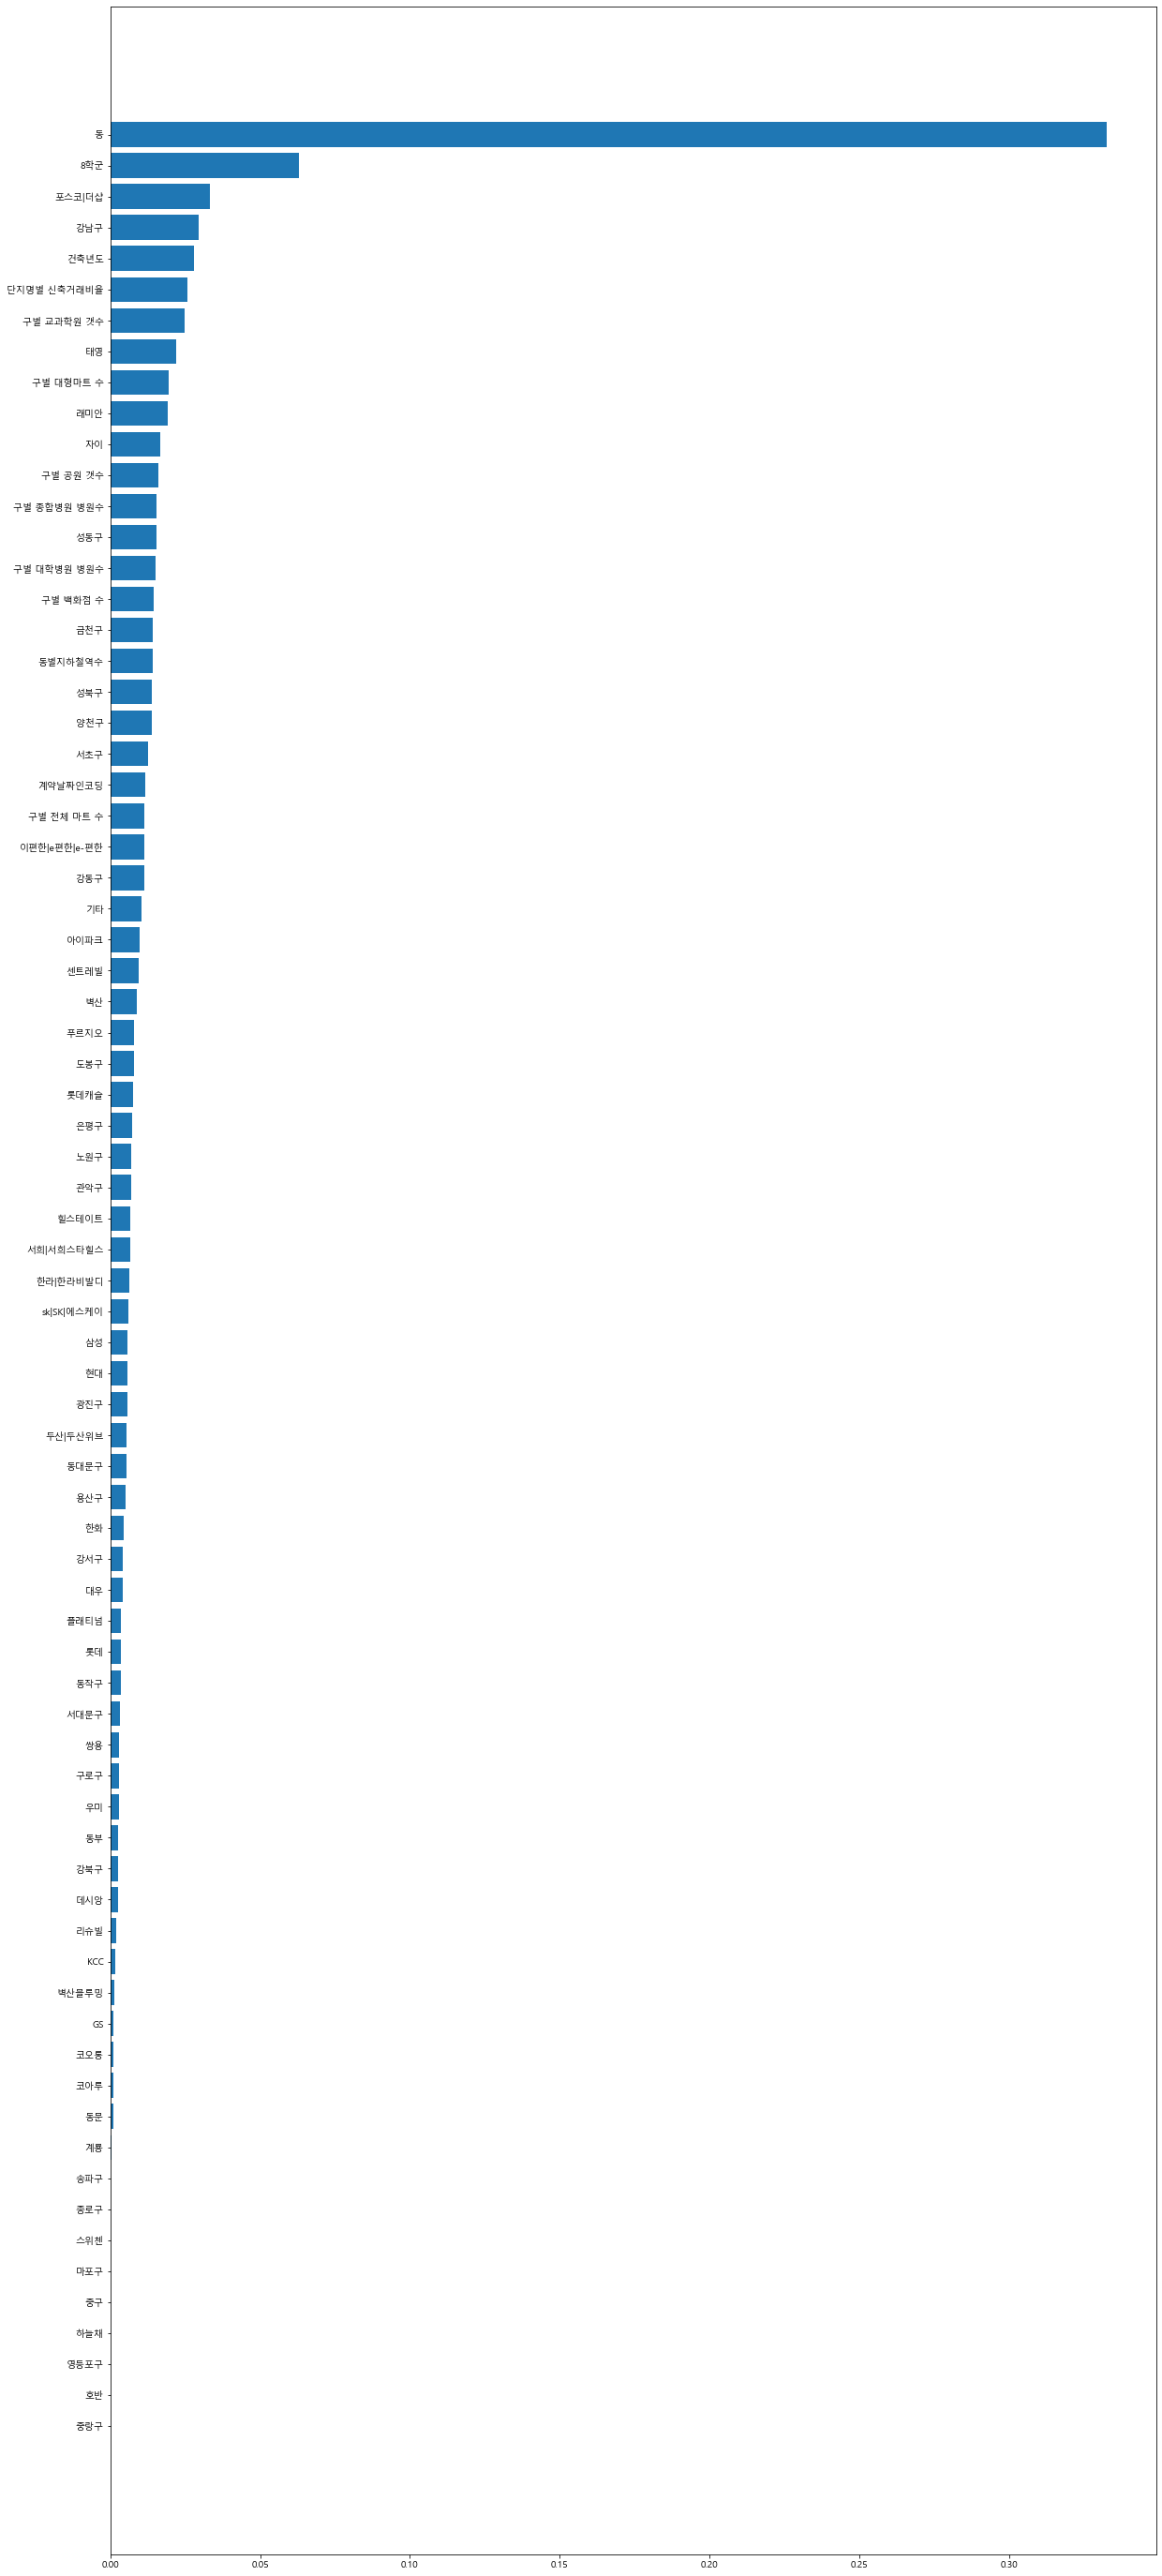

In [44]:
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic") # matplotlib 한글깨짐 방지
plt.figure(figsize=(20,50))
sorted_idx = clf.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], clf.feature_importances_[sorted_idx])

### 3. 파라미터 튜닝

In [7]:
# 3. test get_best_param function

# linear regression model object
def linear_object(trial:Trial, data, target):
    params = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False])
    }
    
    test_model = LinearRegression(**params)
    test_model_score = execute_modeling(('LR', test_model), data, target)

    return test_model_score

# xgbr regression model object
def xgbr_object(trial:Trial, data, target):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 500, 1000),
        'max_depth':trial.suggest_int('max_depth', 8, 16),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 100),
        'gamma':trial.suggest_int('gamma', 1, 3),
        'learning_rate': 0.01,
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1.0),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0] ),
        'random_state': 42
    }
    
    test_model = xgb.XGBRegressor(**params)
    test_model_score = execute_modeling(('XGBR', test_model), data, target)

    return test_model_score

# light gbm regression model object
def lgb_object(trial:Trial, data, target):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 500, 1000),
        'max_depth':trial.suggest_int('max_depth', 8, 16),
        'min_child_weight':trial.suggest_int('min_child_weight', 1, 100)
    }
    
    test_model = lgb.LGBMRegressor(**params)
    test_model_score = execute_modeling(('LGBM', test_model), data, target)

    return test_model_score

# 하이퍼 파라미터 결과 도출
# 위에서 분할한  X_train, y_train, X_test, y_test 파라미터 삽입
study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial: lgb_object(trial, train_x, train_y), n_trials=3)

best_score = study.best_value
best_param_dict = study.best_trial.params

print(best_score, best_param_dict)

[I 2021-12-28 16:21:42,984] A new study created in memory with name: no-name-aa9728d7-5b52-4b7f-a314-9ab0fc9daa4f
[I 2021-12-28 16:22:21,732] Trial 0 finished with value: 25895.329099756465 and parameters: {'n_estimators': 790, 'max_depth': 14, 'min_child_weight': 43}. Best is trial 0 with value: 25895.329099756465.


LGBM average rmse_scores: 25895.329099756465, rmse_scores: [19576.06321571 19376.58158036 55598.44322939 56276.78036999
 29394.86794348 12642.15597452 12019.52356509 25045.80398683
 21638.95337171 34075.15963913 14420.76480632 13809.82873753
 21766.47121174 26651.99570745 26136.5431571 ]


[I 2021-12-28 16:23:02,077] Trial 1 finished with value: 26214.330928425254 and parameters: {'n_estimators': 750, 'max_depth': 9, 'min_child_weight': 64}. Best is trial 0 with value: 25895.329099756465.


LGBM average rmse_scores: 26214.330928425254, rmse_scores: [19831.40428064 20039.21382514 54863.88110247 56009.72590423
 29900.24350841 13507.73394071 12359.79148079 25557.985213
 22598.22387112 34117.80646005 14865.52649845 13909.8459276
 21980.87217221 27063.63479704 26609.07494452]


[I 2021-12-28 16:23:40,147] Trial 2 finished with value: 25739.27317819786 and parameters: {'n_estimators': 727, 'max_depth': 14, 'min_child_weight': 21}. Best is trial 2 with value: 25739.27317819786.


LGBM average rmse_scores: 25739.27317819786, rmse_scores: [19982.4711522  19401.4453833  55313.02189458 56188.8881972
 29589.53745901 12440.62745936 11658.56881514 24586.18736491
 21635.68308552 33538.90012906 14624.16575483 13800.14089515
 21483.4692944  26478.39201484 25367.59877348]
25739.27317819786 {'n_estimators': 727, 'max_depth': 14, 'min_child_weight': 21}


In [8]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study)

In [9]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

### 최종 모형 검증

In [106]:
# 각 모델에 대하여 실질적 학습 수행
# execute_modeling 함수에서 실행한 결과에서 성능 가장 좋은 모델 선정하여 검증 ㄱㄱ

# model = xgb.XGBRegressor()
model = RandomForestRegressor(n_estimators=5)
model.fit(train_x, train_y)
pred_train = model.predict(train_x)

# pred = model.predict(test_x)
print(pred_train)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(test_y, pred)
mse_train = mean_squared_error(train_y, pred_train)

rmse = np.sqrt(mse)
rmse_train = np.sqrt(mse_train)

r2 = r2_score(test_y, pred)
r2_train = r2_score(train_y, pred_train)
print(' ')
print('train')
print('RMSE: ',rmse_train)
print('R^2: ', r2_train )
print(' ')
print('test')
print('RMSE: ',rmse)
print('R^2: ', r2 )


# execute_modeling(('model_xgb', model), test_x, test_y)

[5435.68673072 5113.81602921 5328.39649688 ... 1866.18718455 2179.02000528
 1268.4435068 ]
 
train
RMSE:  242.75230322734606
R^2:  0.9784782869432734
 
test
RMSE:  870.7773921507347
R^2:  0.749509254524893


In [ ]:
'''
# 모든 데이터
   
    *모델 score*
RF average r2: 0.5272973000418608, score_list r2: [0.13219856 0.51651009 0.48258216 0.82794891 0.56851242 0.60397585
 0.55935312]
RF average neg_mean_squared_error: 880.1900126847287, score_list neg_mean_squared_error: [ 474.64765858 1156.10258015  985.13257209 1010.37012195  557.33120699
  641.23304911 1336.51289993]
RF 학습완료
model_xgb average r2: 0.5915764411745851, score_list r2: [0.03094907 0.49068895 0.59252312 0.79804853 0.65838259 0.76010322
 0.8103396 ]
model_xgb average neg_mean_squared_error: 767.0382564144693, score_list neg_mean_squared_error: [ 539.48001704 1049.87832906  837.2110971  1076.82570271  493.57398292
  531.23398039  841.06468568]
model_xgb 학습완료
model_lgb average r2: 0.6035898598493977, score_list r2: [0.10151401 0.54162917 0.61602975 0.81672236 0.61842359 0.72095424
 0.8098559 ]
model_lgb average neg_mean_squared_error: 755.8167943585235, score_list neg_mean_squared_error: [ 519.4667045   995.99212776  812.70377911 1025.83296161  521.64256753
  572.94291513  842.13650489]
model_lgb 학습완료

    *검증 score*
RMSE:  1019.4182893482093
R^2:  0.6566933332187974

# 모든 데이터에서 층 제외

    *모델 점수*
RF average r2: 0.48980736149089743, score_list r2: [0.12367379 0.33855814 0.46794551 0.80822492 0.56304629 0.57949978
 0.5477031 ]
 33%|████████████████████████████                                                        | 1/3 [00:26<00:52, 26.31s/it]
RF average neg_mean_squared_error: 878.0218878090394, score_list neg_mean_squared_error: [ 517.6899633  1072.92850981  961.13588019 1068.87787371  608.18907851
  683.49794916 1233.83395998]
RF 학습완료
model_xgb average r2: 0.5712966746580862, score_list r2: [-0.06409271  0.44013424  0.60506382  0.79183122  0.65626342  0.75355462
  0.81632211]
 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:52, 52.12s/it]
model_xgb average neg_mean_squared_error: 777.8290237111562, score_list neg_mean_squared_error: [ 565.31667459 1100.75172714  824.22721202 1093.27574155  495.10252006
  538.43586397  827.69342665]
model_xgb 학습완료
model_lgb average r2: 0.5925900058054843, score_list r2: [0.08930624 0.51828645 0.60399015 0.81045301 0.60577502 0.71599348
 0.80432569]
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:43<00:00, 34.42s/it]
model_lgb average neg_mean_squared_error: 767.8750711407068, score_list neg_mean_squared_error: [ 522.98380716 1021.0378756   825.34682058 1043.23070056  530.21783266
  578.01325609  854.29520534]
model_lgb 학습완료

    *검증 점수*
train
RMSE:  288.6510080758471
R^2:  0.9695703977598227
test
RMSE:  870.7773921507347
R^2:  0.749509254524893

'''